In [1]:
#Import Modules

import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from torchview import draw_graph


import sys
sys.path.insert(0, "C:/Users/asalvi/Documents/Ameya_workspace/DiffusionDataset/ConeCamAngEst/training/") 
from modules.dataset import CustomDataset
from modules.resnet import get_resnet

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
dataset = CustomDataset(
        csv_file=r"C:\Users\asalvi\Documents\Ameya_workspace\DiffusionDataset\ConeCamAngEst\csv_files\TSyn_data_filtered.csv",
        image_transform=transforms.Compose([
            transforms.Resize((96, 96)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ]),
        input_seq=25, output_seq=100
    )
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
len(dataloader)

258

In [4]:
batch = next(iter(dataloader))

print(f"Image Size:{batch['images'].shape}")     # (64, 25, 3, 96, 96)
print(f"IMU V Size:{batch['imu_v'].shape}")      # (64, 25)
print(f"IMU Omg Size:{batch['imu_omg'].shape}")    # (64, 25)
print(f"Action Size:{batch['actions'].shape}")    # (64, 100, 2)


Image Size:torch.Size([64, 25, 3, 96, 96])
IMU V Size:torch.Size([64, 25])
IMU Omg Size:torch.Size([64, 25])
Action Size:torch.Size([64, 100, 2])


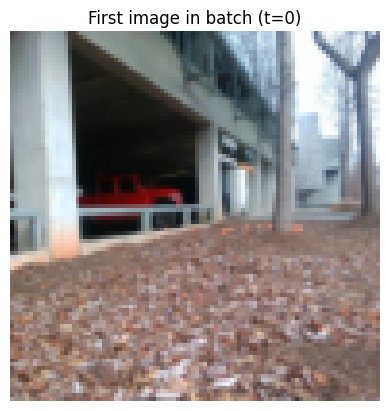

tensor(0.4103, dtype=torch.float64)
tensor(-0.0220, dtype=torch.float64)
tensor([[ 0.0000,  0.0000],
        [ 0.0404,  0.0146],
        [ 0.0746,  0.0259],
        [ 0.1167,  0.0387],
        [ 0.1539,  0.0486],
        [ 0.1924,  0.0577],
        [ 0.2291,  0.0654],
        [ 0.2620,  0.0715],
        [ 0.3069,  0.0785],
        [ 0.3442,  0.0831],
        [ 0.3840,  0.0867],
        [ 0.4194,  0.0890],
        [ 0.4619,  0.0905],
        [ 0.4989,  0.0910],
        [ 0.5409,  0.0902],
        [ 0.5838,  0.0878],
        [ 0.6187,  0.0850],
        [ 0.6595,  0.0807],
        [ 0.6932,  0.0761],
        [ 0.7346,  0.0694],
        [ 0.7773,  0.0608],
        [ 0.8119,  0.0529],
        [ 0.8497,  0.0432],
        [ 0.8866,  0.0326],
        [ 0.9219,  0.0213],
        [ 0.9638,  0.0064],
        [ 1.0061, -0.0103],
        [ 1.0397, -0.0246],
        [ 1.0743, -0.0403],
        [ 1.1097, -0.0578],
        [ 1.1416, -0.0746],
        [ 1.1811, -0.0971],
        [ 1.2102, -0.1146],
   

In [5]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Get image tensor: shape (C, H, W)
img_tensor = batch['images'][0, 0]  # First sample, first timestep

# Convert from [-1, 1] back to [0, 1] for display (because you normalized earlier)
img_tensor = (img_tensor + 1) / 2

# Convert to NumPy array for plotting
img_np = TF.to_pil_image(img_tensor)

# Show the image
plt.imshow(img_np)
plt.title("First image in batch (t=0)")
plt.axis('off')
plt.show()

print(batch['imu_v'][0,0])
print(batch['imu_omg'][0,0])
print(batch['actions'][0,:,:])

In [8]:
images = batch['images']
B, T, C, H, W = images.shape  # [64, 25, 3, 96, 96]
images = images.view(B * T, C, H, W).to(device)   # -> [1600, 3, 96, 96]

vision_encoder = get_resnet().to(device)
image_features = vision_encoder(images)

image_features = image_features.view(B, T, -1)

print(image_features.shape)

torch.Size([64, 25, 2048])


In [10]:
actions = batch["actions"].to(device)

from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
diffusion_scheduler = DDPMScheduler(num_train_timesteps=1000)

# Sample timesteps
timestep = torch.randint(0, diffusion_scheduler.config.num_train_timesteps, (actions.size(0),), device=device)


            # Generate noise
noise = torch.randn_like(actions, device=device)
            # Add noise using DDPM method
noisy_actions = diffusion_scheduler.add_noise(actions, noise, timestep)

print(noisy_actions.shape)


torch.Size([64, 100, 2])
